In [1]:
import sys
sys.path.insert(0, '..')
sys.path.append('.')

In [3]:
import numpy as np
import imageio
import matplotlib.pyplot as plt
import deeptrack as dt
from andi_datasets.models_phenom import models_phenom

### 1. Single state diffusion

In [4]:
T = 500 # number of time steps (frames)
N = 50 # number of particles (trajectories)
L = 1.5 * 128 # length of the box (pixels) -> exteneding fov by 1.5 times
D = 0.1 # diffusion coefficient (pixels^2/frame)

In [5]:
trajs_model1, labels = models_phenom().single_state(N=N, L=L, T=T, D=D, alpha=0.5)

In [6]:
trajs_model1.shape

(500, 50, 2)

### 2. Multi state diffusion

In [7]:
trajs_model2, labels_model2 = models_phenom().multi_state(
    N=N,
    L=L,
    T=T,
    alphas=[1.2, 0.7],
    Ds=[10 * D, 0.1 * D],
    M=np.array([[0.98, 0.02], [0.02, 0.98]]),
)

In [8]:
trajs_model2.shape

(500, 50, 2)

### 3. Dimerization

In [9]:
trajs_model3, labels_model3 = models_phenom().dimerization(
    N=N,
    L=L,
    T=T,
    alphas=[1.2, 0.7],
    Ds=[10 * D, 0.1 * D],
    r=1,  # radius of the particles
    Pb=1,  # binding probability
    Pu=0,  # unbinding probability
)

  0%|          | 0/499 [00:00<?, ?it/s]

In [10]:
trajs_model3.shape

(500, 50, 2)

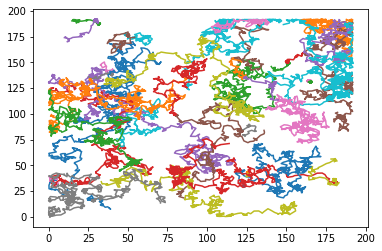

In [11]:
t3 = np.moveaxis(trajs_model3, 0, 1)
for traj in t3:
    plt.plot(traj[:,0], traj[:,1])
plt.show()

### 4. Immobile traps

In [12]:
number_traps = 100
traps_positions = np.random.rand(number_traps, 2)*L/2 

In [13]:
trajs_model4, labels_model4 = models_phenom().immobile_traps(
    N=N,
    T=T,
    L=L,
    r=1,  # radius of the traps
    Pu=0.01,  # Unbinding probability
    Pb=1,  # Binding probability
    D=D,  # Diffusion coefficients of moving state
    alpha=1.6,  # Anomalous exponents of moving state
    Nt=number_traps,  # number of traps
    traps_pos=traps_positions,
)

  0%|          | 0/499 [00:00<?, ?it/s]

In [14]:
trajs_model4.shape

(500, 50, 2)

### 5. Confinement

In [15]:
number_compartments = 100
radius_compartments = 10
compartments_center = models_phenom._distribute_circular_compartments(
    Nc=number_compartments, r=radius_compartments, L=L  # size of the environment
)

/Users/harshithbachimanchi/Desktop/Repositories/andi_datasets/tutorials/../andi_datasets/models_phenom.py:560: UserWarning: Could accomodate 57 circles of the 100 requested. Increase size of environment or decrease radius of compartments.
  warnings.warn(warn_str)


In [16]:
trajs_model5, labels_model5 = models_phenom().confinement(
    N=N,
    L=L,
    Ds=[1500 * D, 50 * D],
    comp_center=compartments_center,
    r=radius_compartments,
    trans=0.2,  # boundary transmittance
)

/Users/harshithbachimanchi/Desktop/Repositories/andi_datasets/tutorials/../andi_datasets/utils_trajectories.py:41: RuntimeWarning: divide by zero encountered in true_divide
  val = scipy.stats.truncnorm.rvs((lower-mean)/np.sqrt(var),
/Users/harshithbachimanchi/Desktop/Repositories/andi_datasets/tutorials/../andi_datasets/utils_trajectories.py:42: RuntimeWarning: divide by zero encountered in true_divide
  (upper-mean)/np.sqrt(var),


### 6. To generate videos from trajectories


Import ``get_video_andi`` function

In [17]:
from andi_datasets.utils_videos import get_video_andi

### 6.1. Generating videos
``get_video_andi`` will create a feature required to generate videos in deeptrack. 

In [18]:
origin = 0 # pixels
video = get_video_andi(trajs_model1, optics_kwargs={"output_region": [origin, origin, 200, 200]}) #change the output region to see the video

To store generated videos as a sequence of frames use ``update().resolve()``

In [20]:
video_frames = video.update().resolve()

Plot the trajectories on the first frame of the video

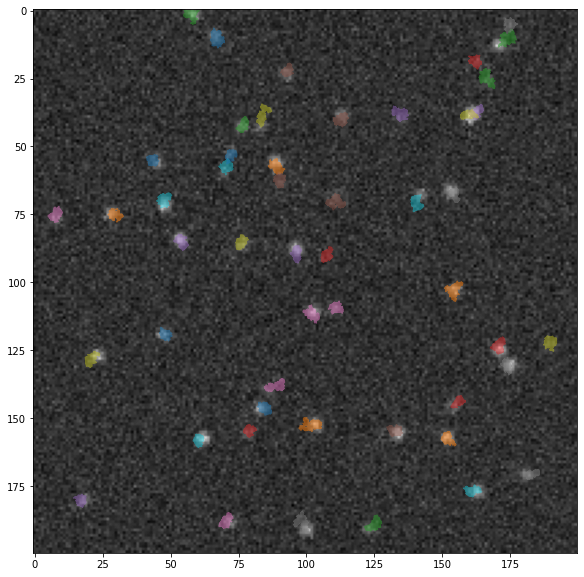

In [21]:
plt.figure(figsize=(10, 10))
plt.imshow(video_frames[0], cmap="gray")
for traj in np.moveaxis(trajs_model1, 0, 1):
    plt.plot(traj[:,1][:1000], traj[:,0][:1000], alpha=0.5)
plt.show()

Alternatively the videos can played directly in jupyter notebook, using ``plot()`` module class after ``update()``

In [ ]:
video.update().plot(cmap="gray")

### 6.2 Save the videos

In [ ]:
def convert_uint8(vid):
    new_vid = []
    for im in vid:
        im = im[:,:,0]
        im = im / im.max()
        im = im * 255
        im = im.astype(np.uint8)
        new_vid.append(im)
    return new_vid

In [ ]:
# change the path accordingly
save_path = "../videos/video.mp4"

In [ ]:
video_frames_uint8 = convert_uint8(video_frames)
imageio.mimwrite(save_path, video_frames_uint8, fps=10)